In [1]:
%matplotlib inline

In [2]:
from keras.layers.core import Dense, MaxoutDense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn import cross_validation
from sklearn.metrics import auc, roc_curve
import h5py
import matplotlib.pyplot as plt
import numpy as np

Using Theano backend.


In [3]:
max_n_s = 10000

X = []
Y = []
with h5py.File('images/w_shrink_1p2.h5', 'r') as infile:
    n_s = min(len(infile['images']['image']), max_n_s)
    images = infile['images']['image'][:n_s]
    images = images.reshape(-1, images.shape[1] * images.shape[2])
    X.append(images)
    Y.append(np.repeat([[1, 0]], images.shape[0], axis=0))
with h5py.File('images/qcd_shrink_1p2.h5', 'r') as infile:
    n_s = min(len(infile['images']['image']), max_n_s)
    images = infile['images']['image'][:n_s]
    images = images.reshape(-1, images.shape[1] * images.shape[2])
    X.append(images)
    Y.append(np.repeat([[0, 1]], images.shape[0], axis=0))
X = np.concatenate(X)
Y = np.concatenate(Y)

In [4]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.5)

In [5]:
epochs     = 100
patience   = 10
batch_size = 32

model = Sequential()
model.add(MaxoutDense(input_shape=(625,), output_dim=256, nb_feature=5, init='he_uniform'))
model.add(MaxoutDense(output_dim=128, nb_feature=5))
model.add(Dense(output_dim=64, activation='relu'))
model.add(Dense(output_dim=25, activation='relu'))
model.add(Dense(output_dim=2, activation='sigmoid'))
optimizer = Adam()

In [6]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
X_fit, X_val, Y_fit, Y_val = cross_validation.train_test_split(X_train, Y_train, test_size=0.1)
best_auc = 0.
stop_cdn = 0
res = 1. / max_n_s
for epoch in range(epochs):
    print "Epoch {0}/{1}...".format(epoch + 1, epochs)
    model.fit(X_fit, Y_fit, nb_epoch=1, batch_size=batch_size, verbose=0)
    Y_prob = model.predict_proba(X_val, batch_size=batch_size, verbose=0)
    Y_prob /= Y_prob.sum(axis=1)[:,np.newaxis]
    fpr, tpr, thresholds = roc_curve(Y_val[:, 0], Y_prob[:, 0])
    inv_curve = np.array(
        [[tp, 1./max(fp,res)]
        for tp,fp in zip(tpr,fpr) if (0.2 <= tp <= 0.8 and fp > 0.)])
    current_auc = auc(inv_curve[:, 0], inv_curve[:, 1])
    if current_auc > best_auc:
        best_auc = current_auc
        stop_cdn = 0
        model.save_weights("best_model_alt.h5", overwrite=True)
    else:
        stop_cdn += 1
    print "Epochs w/o increase = {0}, AUC = {1}".format(stop_cdn, current_auc)
    if stop_cdn >= patience:
        print "Patience tolerance reached"
        break
print "Training complete"

Epoch 1/100...
Epochs w/o increase = 0, AUC = 7.15999629841
Epoch 2/100...
Epochs w/o increase = 0, AUC = 10.549803669
Epoch 3/100...
Epochs w/o increase = 0, AUC = 24.5677041884
Epoch 4/100...
Epochs w/o increase = 1, AUC = 13.8723389735
Epoch 5/100...
Epochs w/o increase = 2, AUC = 11.7746541236
Epoch 6/100...
Epochs w/o increase = 3, AUC = 21.3212242692
Epoch 7/100...
Epochs w/o increase = 4, AUC = 12.9260915361
Epoch 8/100...
Epochs w/o increase = 5, AUC = 18.6831078999
Epoch 9/100...
Epochs w/o increase = 6, AUC = 24.0374331588
Epoch 10/100...
Epochs w/o increase = 7, AUC = 19.7174861766
Epoch 11/100...
Epochs w/o increase = 0, AUC = 27.7963583254
Epoch 12/100...
Epochs w/o increase = 1, AUC = 23.0502711491
Epoch 13/100...
Epochs w/o increase = 2, AUC = 20.0771819481
Epoch 14/100...
Epochs w/o increase = 3, AUC = 27.2237393076
Epoch 15/100...
Epochs w/o increase = 4, AUC = 27.1059842058
Epoch 16/100...
Epochs w/o increase = 0, AUC = 29.2263079853
Epoch 17/100...
Epochs w/o increas

Score    = 0.51993461132
AUC      = 27.2805122733
Accuracy = 7597/10000 = 0.7597


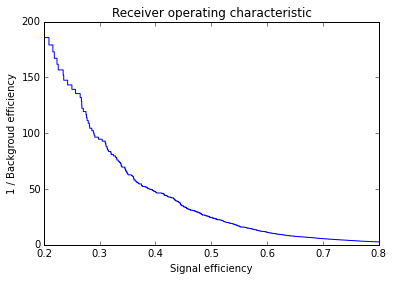

In [11]:
model.load_weights("best_model.h5")
objective_score = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
Y_prob  = model.predict_proba(X_test, batch_size=batch_size, verbose=0)
Y_prob /= Y_prob.sum(axis=1)[:,np.newaxis]
fpr, tpr, _ = roc_curve(Y_test[:,0], Y_prob[:,0])
inv_curve = np.array([ [tp, 1.0/max(fp,res)]
    for tp,fp in zip(tpr,fpr) if 0.2 <= tp <= 0.8 ])
final_auc = auc(inv_curve[:,0], inv_curve[:,1])
Y_pred = model.predict_classes(X_test, batch_size=batch_size, verbose=0)
accuracy = sum([1 for i in range(len(Y_test)) if Y_test[i,Y_pred[i]] == 1.0])

print "Score    = {0}".format(objective_score)
print "AUC      = {0}".format(final_auc)
print "Accuracy = {0}/{1} = {2}".format(
    accuracy, len(Y_test), float(accuracy) / len(Y_test) )
plt.figure()
plt.plot(inv_curve[:,0], inv_curve[:,1])
plt.xlabel("Signal efficiency")
plt.ylabel("1 / Backgroud efficiency")
plt.title("Receiver operating characteristic")
plt.show()